In [101]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# used to supress display of warnings
import warnings

from sklearn.metrics import precision_recall_curve,accuracy_score,f1_score,precision_score,recall_score

import os

import cv2

from tensorflow.keras.models import load_model

import random, copy, math, time

In [102]:
from utils import *

In [103]:
with open("model_utils.pkl","rb") as f:
    metadata, embeddings, pipeline, le = pickle.load(f)

In [149]:
x = embeddings

In [150]:
y = np.array([m.name for m in metadata])

In [106]:
f.close()

In [151]:
from sklearn.model_selection import train_test_split

In [152]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, stratify = y)

In [153]:
import pandas as pd

In [154]:
pd.Series(y_train).value_counts()

pins_Leonardo DiCaprio     189
pins_Robert Downey Jr      185
pins_Katherine Langford    182
pins_Alexandra Daddario    179
pins_elizabeth olsen       176
                          ... 
pins_jeff bezos             84
pins_Morgan Freeman         83
pins_Cristiano Ronaldo      78
pins_Mark Zuckerberg        75
pins_Lionel Messi           68
Length: 105, dtype: int64

In [155]:
len(np.unique(y_train))

105

In [156]:
pd.Series(y_test=='pins_Tom Holland').value_counts()

False    3460
True       38
dtype: int64

In [157]:
len(np.unique(y_test))

105

In [158]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

scaler = StandardScaler()
x_train_std = scaler.fit_transform(x_train)

In [159]:
x_test_std = scaler.transform(x_test)

In [160]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128)
x_train_pca = pca.fit_transform(x_train_std)
x_test_pca = pca.transform(x_test_std)

In [161]:
le2 = LabelEncoder()
y_train_encoded = le2.fit_transform(y_train)

In [162]:
print(le2.classes_)
y_test_encoded = le2.transform(y_test)

['pins_Adriana Lima' 'pins_Alex Lawther' 'pins_Alexandra Daddario'
 'pins_Alvaro Morte' 'pins_Amanda Crew' 'pins_Andy Samberg'
 'pins_Anne Hathaway' 'pins_Anthony Mackie' 'pins_Avril Lavigne'
 'pins_Ben Affleck' 'pins_Bill Gates' 'pins_Bobby Morley'
 'pins_Brenton Thwaites' 'pins_Brian J. Smith' 'pins_Brie Larson'
 'pins_Chris Evans' 'pins_Chris Hemsworth' 'pins_Chris Pratt'
 'pins_Christian Bale' 'pins_Cristiano Ronaldo' 'pins_Danielle Panabaker'
 'pins_Dominic Purcell' 'pins_Dwayne Johnson' 'pins_Eliza Taylor'
 'pins_Elizabeth Lail' 'pins_Emilia Clarke' 'pins_Emma Stone'
 'pins_Emma Watson' 'pins_Gwyneth Paltrow' 'pins_Henry Cavil'
 'pins_Hugh Jackman' 'pins_Inbar Lavi' 'pins_Irina Shayk'
 'pins_Jake Mcdorman' 'pins_Jason Momoa' 'pins_Jennifer Lawrence'
 'pins_Jeremy Renner' 'pins_Jessica Barden' 'pins_Jimmy Fallon'
 'pins_Johnny Depp' 'pins_Josh Radnor' 'pins_Katharine Mcphee'
 'pins_Katherine Langford' 'pins_Keanu Reeves' 'pins_Krysten Ritter'
 'pins_Leonardo DiCaprio' 'pins_Lili R

In [163]:
print('y_train_encoded : ', y_train_encoded)
print('y_test_encoded : ', y_test_encoded)

y_train_encoded :  [66 51 59 ... 20 39  4]
y_test_encoded :  [20 25 82 ... 62  0 50]


In [164]:
from sklearn.svm import SVC, OneClassSVM
from sklearn.neural_network import MLPClassifier

In [165]:
clf = SVC(C=5., gamma=0.001, probability = True)
clf.fit(x_train_pca, y_train_encoded)

SVC(C=5.0, gamma=0.001, probability=True)

In [166]:
clf.score(x_test_pca,y_test_encoded)

0.9608347627215552

In [167]:
mlp = MLPClassifier(max_iter=10000)
mlp.fit(x_train_pca, y_train_encoded)
mlp.score(x_test_pca,y_test_encoded)

0.9562607204116638

In [168]:
# Load pre-trained face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_faces(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
    return faces

In [169]:
embedder = load_model("vgg_face_embedder.h5")

Maximum Probabilities:
0.999273758219017 - scarlett johansson
0.9999759578198311 - Mark Ruffalo
0.9997570877319968 - Chris Hemsworth
0.9995495886452482 - Robert Downey Jr
0.9986139758973309 - Chris Evans
0.9999985743725477 - Tom Hiddleston
0.9999814482535724 - Jeremy Renner

Total Execution Time in Seconds:
4.273983716964722 s


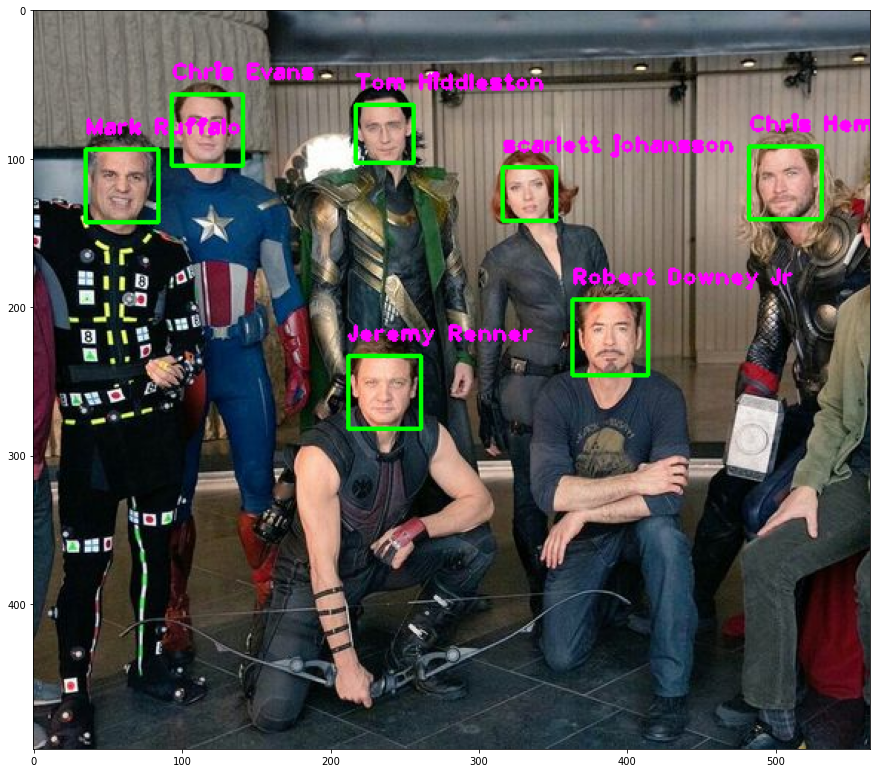

In [193]:
name = 'avengers'
start = time.time()
try:
    inp_img = cv2.imread(rf"D:\Users\DELL\Desktop\Major Project\Github Face Rec\test_images\{name}.jpg")
except:
    inp_img = cv2.imread(rf"D:\Users\DELL\Desktop\Major Project\Github Face Rec\test_images\{name}.jpeg")
gray=cv2.cvtColor(inp_img, cv2.COLOR_BGR2GRAY)
inp_faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
ct = 0
new_img = copy.deepcopy(inp_img)
print("Maximum Probabilities:")
for (x, y, w, h) in inp_faces:
    input_face_region = inp_img[y:y+h, x:x+w]
    img = (input_face_region / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embedding_vector = embedder.predict(np.expand_dims(img, axis=0),verbose=0)[0]
    embv_scaled = scaler.transform([embedding_vector])
    embv_pca = pca.transform(embv_scaled)
    #name = le.inverse_transform(mlp.predict(embv_pca))[0][5:]
    probabs = mlp.predict_proba(embv_pca)
    if np.max(probabs) > 0.97:
        name = le2.inverse_transform([np.argmax(probabs)])[0][5:]
    else:
        name = 'not recognized'
    print(np.max(probabs),"-", name)
    cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),2)
    new_img = cv2.putText(new_img,name,(x,y-10),cv2.FONT_HERSHEY_PLAIN,1,(255,0,255),2,cv2.LINE_4)
new_img = new_img[...,::-1]
plt.figure(figsize=(15,15))
plt.imshow(new_img)
end = time.time()
print("\nTotal Execution Time in Seconds:")
print(end-start,"s")

Maximum Probabilities:
0.999033949955968 - Dwayne Johnson
0.9751941342508151 - Tom Holland

Total Execution Time in Seconds:
2.279930591583252 s


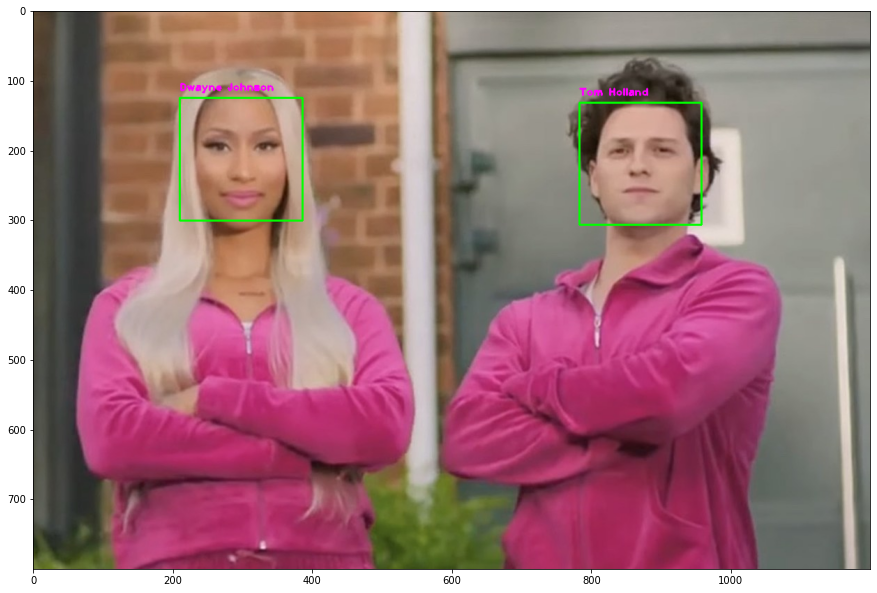

In [194]:
name = 'nicki_minaj-tom_holland'
start = time.time()
try:
    inp_img = cv2.imread(rf"D:\Users\DELL\Desktop\Major Project\Github Face Rec\test_images\{name}.jpg")
except:
    inp_img = cv2.imread(rf"D:\Users\DELL\Desktop\Major Project\Github Face Rec\test_images\{name}.jpeg")
gray=cv2.cvtColor(inp_img, cv2.COLOR_BGR2GRAY)
inp_faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
ct = 0
new_img = copy.deepcopy(inp_img)
print("Maximum Probabilities:")
for (x, y, w, h) in inp_faces:
    input_face_region = inp_img[y:y+h, x:x+w]
    img = (input_face_region / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embedding_vector = embedder.predict(np.expand_dims(img, axis=0),verbose=0)[0]
    embv_scaled = scaler.transform([embedding_vector])
    embv_pca = pca.transform(embv_scaled)
    #name = le.inverse_transform(mlp.predict(embv_pca))[0][5:]
    probabs = mlp.predict_proba(embv_pca)
    if np.max(probabs) > 0.97:
        name = le2.inverse_transform([np.argmax(probabs)])[0][5:]
    else:
        name = 'not recognized'
    print(np.max(probabs),"-", name)
    cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),2)
    new_img = cv2.putText(new_img,name,(x,y-10),cv2.FONT_HERSHEY_PLAIN,1,(255,0,255),2,cv2.LINE_4)
new_img = new_img[...,::-1]
plt.figure(figsize=(15,15))
plt.imshow(new_img)
end = time.time()
print("\nTotal Execution Time in Seconds:")
print(end-start,"s")

Maximum Probabilities:
0.8406605179893576 - not recognized
0.9979061313883854 - Ben Affleck
0.9999973896427691 - gal gadot
0.5422586472579699 - not recognized

Total Execution Time in Seconds:
2.833608627319336 s


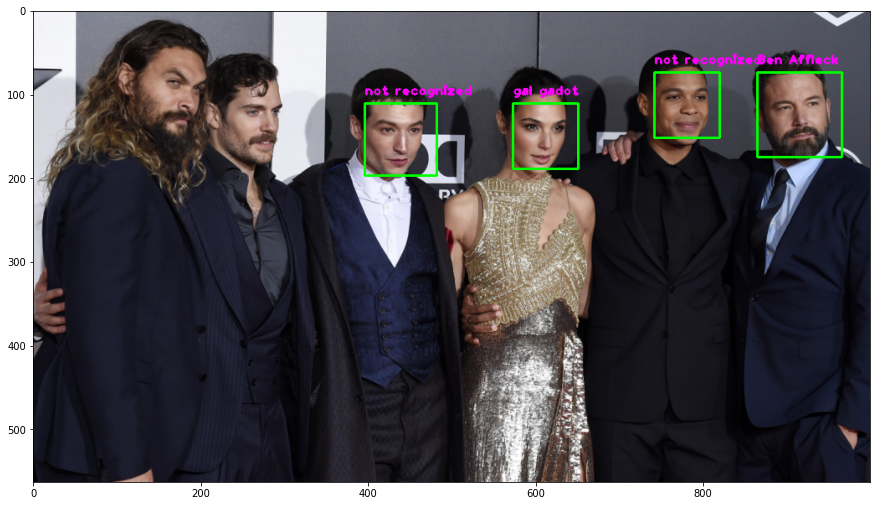

In [195]:
name = 'justice_league'
start = time.time()
try:
    inp_img = cv2.imread(rf"D:\Users\DELL\Desktop\Major Project\Github Face Rec\test_images\{name}.jpg")
except:
    inp_img = cv2.imread(rf"D:\Users\DELL\Desktop\Major Project\Github Face Rec\test_images\{name}.jpeg")
gray=cv2.cvtColor(inp_img, cv2.COLOR_BGR2GRAY)
inp_faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
ct = 0
new_img = copy.deepcopy(inp_img)
print("Maximum Probabilities:")
for (x, y, w, h) in inp_faces:
    input_face_region = inp_img[y:y+h, x:x+w]
    img = (input_face_region / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embedding_vector = embedder.predict(np.expand_dims(img, axis=0),verbose=0)[0]
    embv_scaled = scaler.transform([embedding_vector])
    embv_pca = pca.transform(embv_scaled)
    #name = le.inverse_transform(mlp.predict(embv_pca))[0][5:]
    probabs = mlp.predict_proba(embv_pca)
    if np.max(probabs) > 0.97:
        name = le2.inverse_transform([np.argmax(probabs)])[0][5:]
    else:
        name = 'not recognized'
    print(np.max(probabs),"-", name)
    cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),2)
    new_img = cv2.putText(new_img,name,(x,y-10),cv2.FONT_HERSHEY_PLAIN,1,(255,0,255),2,cv2.LINE_4)
new_img = new_img[...,::-1]
plt.figure(figsize=(15,15))
plt.imshow(new_img)
end = time.time()
print("\nTotal Execution Time in Seconds:")
print(end-start,"s")

Maximum Probabilities:
0.7263332041952344 - not recognized

Total Execution Time in Seconds:
1.4209742546081543 s


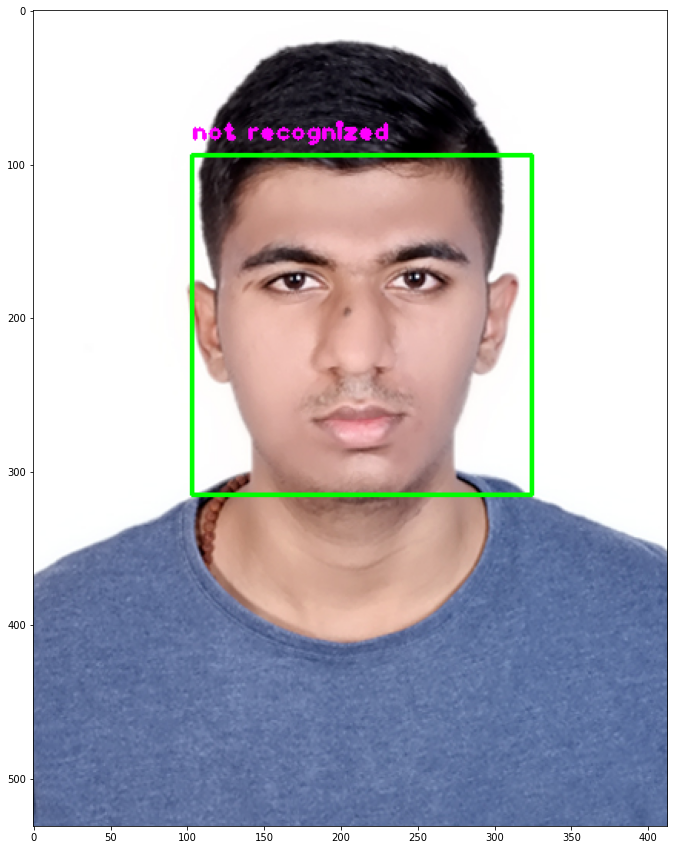

In [196]:
name = 'dhruv_limbani'
start = time.time()
try:
    inp_img = cv2.imread(rf"D:\Users\DELL\Desktop\Major Project\Github Face Rec\test_images\{name}.jpg")
except:
    inp_img = cv2.imread(rf"D:\Users\DELL\Desktop\Major Project\Github Face Rec\test_images\{name}.jpeg")
gray=cv2.cvtColor(inp_img, cv2.COLOR_BGR2GRAY)
inp_faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
ct = 0
new_img = copy.deepcopy(inp_img)
print("Maximum Probabilities:")
for (x, y, w, h) in inp_faces:
    input_face_region = inp_img[y:y+h, x:x+w]
    img = (input_face_region / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embedding_vector = embedder.predict(np.expand_dims(img, axis=0),verbose=0)[0]
    embv_scaled = scaler.transform([embedding_vector])
    embv_pca = pca.transform(embv_scaled)
    #name = le.inverse_transform(mlp.predict(embv_pca))[0][5:]
    probabs = mlp.predict_proba(embv_pca)
    if np.max(probabs) > 0.97:
        name = le2.inverse_transform([np.argmax(probabs)])[0][5:]
    else:
        name = 'not recognized'
    print(np.max(probabs),"-", name)
    cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),2)
    new_img = cv2.putText(new_img,name,(x,y-10),cv2.FONT_HERSHEY_PLAIN,1,(255,0,255),2,cv2.LINE_4)
new_img = new_img[...,::-1]
plt.figure(figsize=(15,15))
plt.imshow(new_img)
end = time.time()
print("\nTotal Execution Time in Seconds:")
print(end-start,"s")

Maximum Probabilities:
0.5881015993659184 - not recognized
0.9132349095953354 - not recognized

Total Execution Time in Seconds:
1.2773311138153076 s


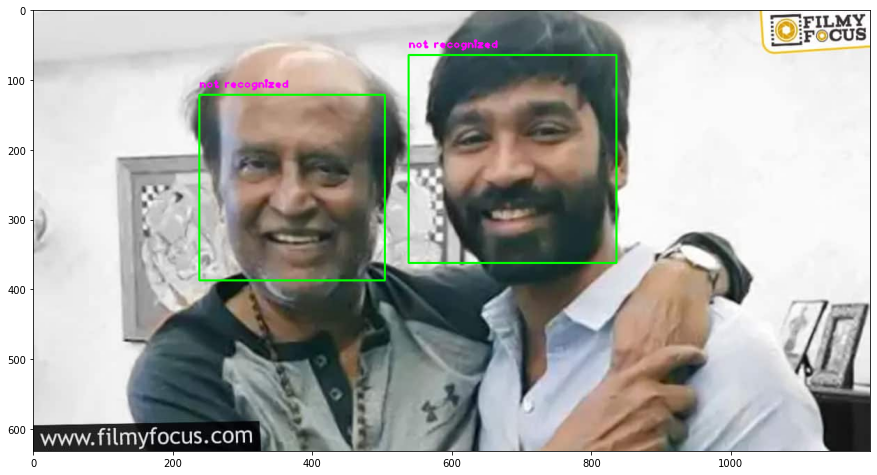

In [197]:
name = 'rajnikanth_dhanush'
start = time.time()
try:
    inp_img = cv2.imread(rf"D:\Users\DELL\Desktop\Major Project\Github Face Rec\test_images\{name}.jpg")
except:
    inp_img = cv2.imread(rf"D:\Users\DELL\Desktop\Major Project\Github Face Rec\test_images\{name}.jpeg")
gray=cv2.cvtColor(inp_img, cv2.COLOR_BGR2GRAY)
inp_faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
ct = 0
new_img = copy.deepcopy(inp_img)
print("Maximum Probabilities:")
for (x, y, w, h) in inp_faces:
    input_face_region = inp_img[y:y+h, x:x+w]
    img = (input_face_region / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embedding_vector = embedder.predict(np.expand_dims(img, axis=0),verbose=0)[0]
    embv_scaled = scaler.transform([embedding_vector])
    embv_pca = pca.transform(embv_scaled)
    #name = le.inverse_transform(mlp.predict(embv_pca))[0][5:]
    probabs = mlp.predict_proba(embv_pca)
    if np.max(probabs) > 0.97:
        name = le2.inverse_transform([np.argmax(probabs)])[0][5:]
    else:
        name = 'not recognized'
    print(np.max(probabs),"-", name)
    cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),2)
    new_img = cv2.putText(new_img,name,(x,y-10),cv2.FONT_HERSHEY_PLAIN,1,(255,0,255),2,cv2.LINE_4)
new_img = new_img[...,::-1]
plt.figure(figsize=(15,15))
plt.imshow(new_img)
end = time.time()
print("\nTotal Execution Time in Seconds:")
print(end-start,"s")

Maximum Probabilities:
0.6862654668242076 - not recognized
0.8758024570233239 - not recognized
0.9647381037482609 - not recognized
0.9999865179643921 - barack obama

Total Execution Time in Seconds:
2.684520959854126 s


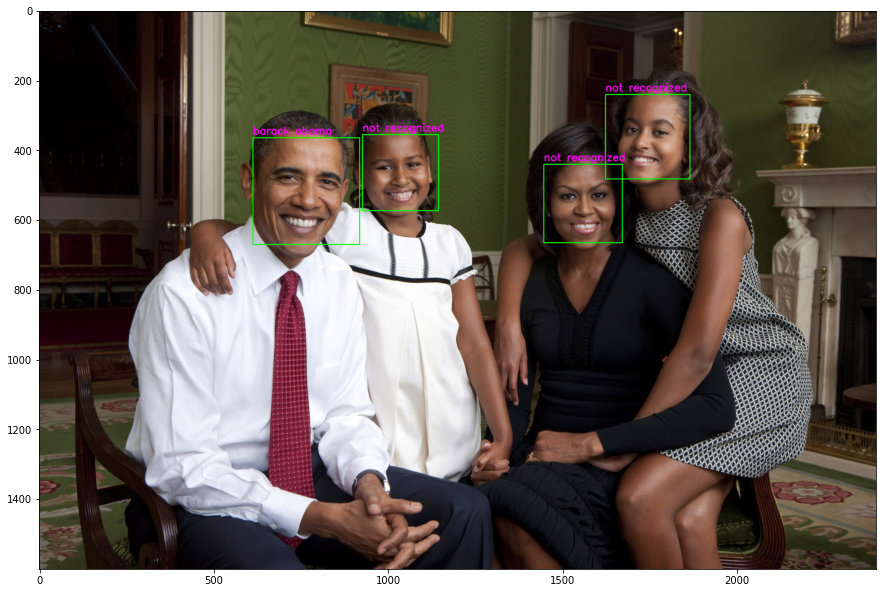

In [199]:
name = 'barack_obama_family'
start = time.time()
try:
    inp_img = cv2.imread(rf"D:\Users\DELL\Desktop\Major Project\Github Face Rec\test_images\{name}.jpg")
except:
    inp_img = cv2.imread(rf"D:\Users\DELL\Desktop\Major Project\Github Face Rec\test_images\{name}.jpeg")
gray=cv2.cvtColor(inp_img, cv2.COLOR_BGR2GRAY)
inp_faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
ct = 0
new_img = copy.deepcopy(inp_img)
print("Maximum Probabilities:")
for (x, y, w, h) in inp_faces:
    input_face_region = inp_img[y:y+h, x:x+w]
    img = (input_face_region / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embedding_vector = embedder.predict(np.expand_dims(img, axis=0),verbose=0)[0]
    embv_scaled = scaler.transform([embedding_vector])
    embv_pca = pca.transform(embv_scaled)
    #name = le.inverse_transform(mlp.predict(embv_pca))[0][5:]
    probabs = mlp.predict_proba(embv_pca)
    if np.max(probabs) > 0.97:
        name = le2.inverse_transform([np.argmax(probabs)])[0][5:]
    else:
        name = 'not recognized'
    print(np.max(probabs),"-", name)
    cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),2)
    new_img = cv2.putText(new_img,name,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,255),2,cv2.LINE_AA)
new_img = new_img[...,::-1]
plt.figure(figsize=(15,15))
plt.imshow(new_img)
end = time.time()
print("\nTotal Execution Time in Seconds:")
print(end-start,"s")

In [200]:
name = "tom_holland"
start = time.time()
try:
    path = rf"D:\Users\DELL\Desktop\Major Project\Github Face Rec\test_images\{name}.jpg"
    print(recognize(path,metadata,embeddings,embedder))
except:
    path = rf"D:\Users\DELL\Desktop\Major Project\Github Face Rec\test_images\{name}.jpeg"
    print(recognize(path,metadata,embeddings,embedder))
end = time.time()
print("\nTotal Execution Time in Seconds:")
print(end-start)

pins_Bill Gates

Total Execution Time in Seconds:
3.6851978302001953


In [176]:
with open("svm-mlp-models.pkl","wb") as f:
    pickle.dump([clf,mlp],f)

In [177]:
f.close()

# Existing Systems:

1) Requires Face images in good lighting conditions for training (mobile face rec unlock) - not ideal for face rec for missing people identification as we need to identify person from whatever images are available

2) Calculates the embeddings of each image in the database (length-2000-4000). To recognize the person, an input image is coverted to same length embedding and that embedding is compared with every other image in the database and a distance is calculated between them. If the distance is lower than threshold, match is found else the person is not recognized.
    
    Advantages:
    - no longer requires images once the embedding is generated. computations can be done on the embeddings itself. privacy is maintained.
    
    
    Disadvantages:
    - takes O(n) time to compare the distances
    - minimum vector leangth of 2000 is required for each image.
    - not suitable for deployment on edge devices as models are 500 mb to 1 gb of size.


# Our Approach

1) Computes the embeddings of each image and further reduces it to 128D vector using PCA
2) Uses SVM algorithm to train on the PCA Vectors
3) Once an image is given as input, it converts it into 128D PCA embedding and then makes probabilistic prediction on the image

    Advantages:
    - no longer requires images once embeddings are generated, privacy is maintained.
    - runs in O(1) time
    - model size is less than 10mb
    - can be deployed easily on edge devices